Architecture:

Autoencoders are a type of neural network that learns the data encodings from the dataset in an unsupervised way. It basically contains two parts: the first one is an encoder which is similar to the convolution neural network except for the last layer. The aim of the encoder to learn efficient data encoding from the dataset and pass it into a bottleneck architecture. The other part of the autoencoder is a decoder that uses latent space in the bottleneck layer to regenerate the images similar to the dataset. These results backpropagate from the neural network in the form of the loss function

Variational autoencoder is different from autoencoder in a way such that it provides a statistic manner for describing the samples of the dataset in latent space. Therefore, in variational autoencoder, the encoder outputs a probability distribution in the bottleneck layer instead of a single output value.

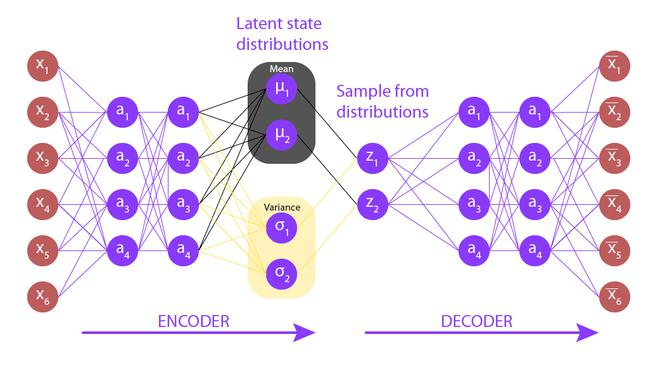

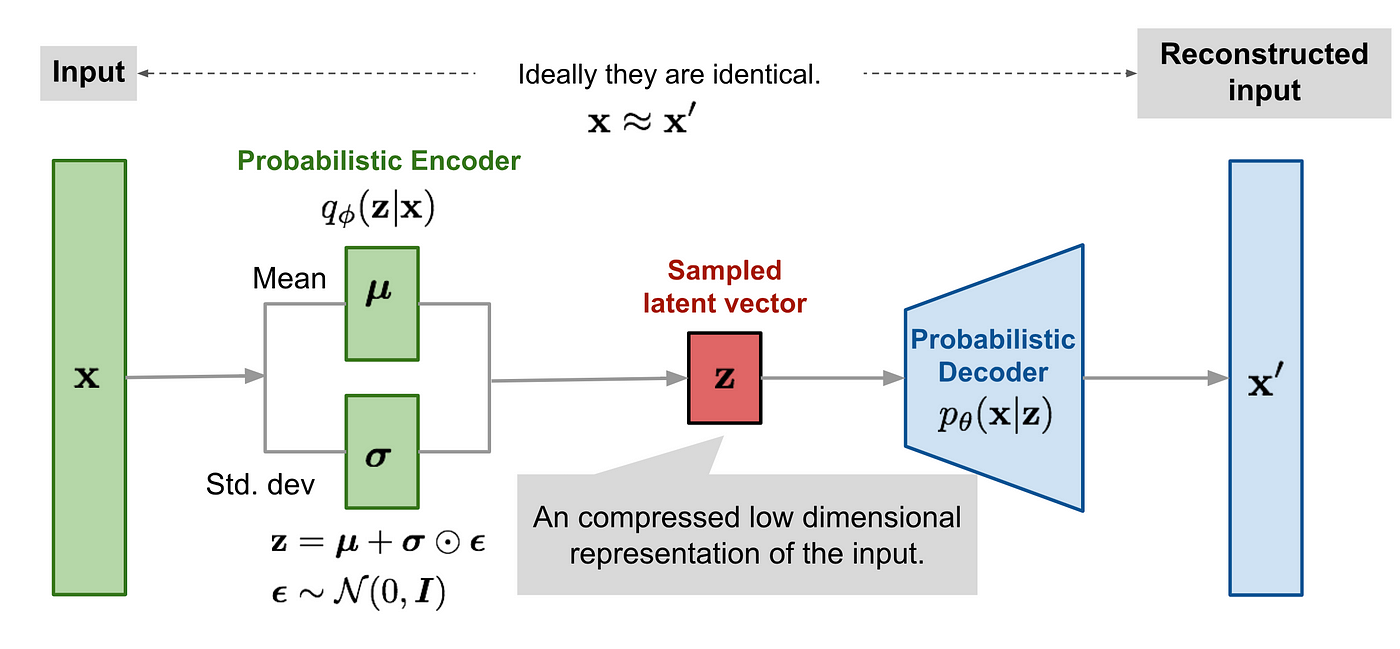

Epoch 1/50
235/235 [==============================] - 13s 44ms/step - loss: 205.1130 - val_loss: 179.5714
Epoch 2/50
235/235 [==============================] - 5s 22ms/step - loss: 174.5020 - val_loss: 171.1778
Epoch 3/50
235/235 [==============================] - 6s 27ms/step - loss: 168.0413 - val_loss: 166.4566
Epoch 4/50
235/235 [==============================] - 5s 22ms/step - loss: 165.1652 - val_loss: 164.0360
Epoch 5/50
235/235 [==============================] - 5s 23ms/step - loss: 163.3202 - val_loss: 162.7354
Epoch 6/50
235/235 [==============================] - 6s 26ms/step - loss: 161.8387 - val_loss: 161.6022
Epoch 7/50
235/235 [==============================] - 5s 22ms/step - loss: 160.6756 - val_loss: 160.5328
Epoch 8/50
235/235 [==============================] - 6s 27ms/step - loss: 159.6933 - val_loss: 160.0152
Epoch 9/50
235/235 [==============================] - 5s 22ms/step - loss: 158.8214 - val_loss: 159.1212
Epoch 10/50
235/235 [==============================] -

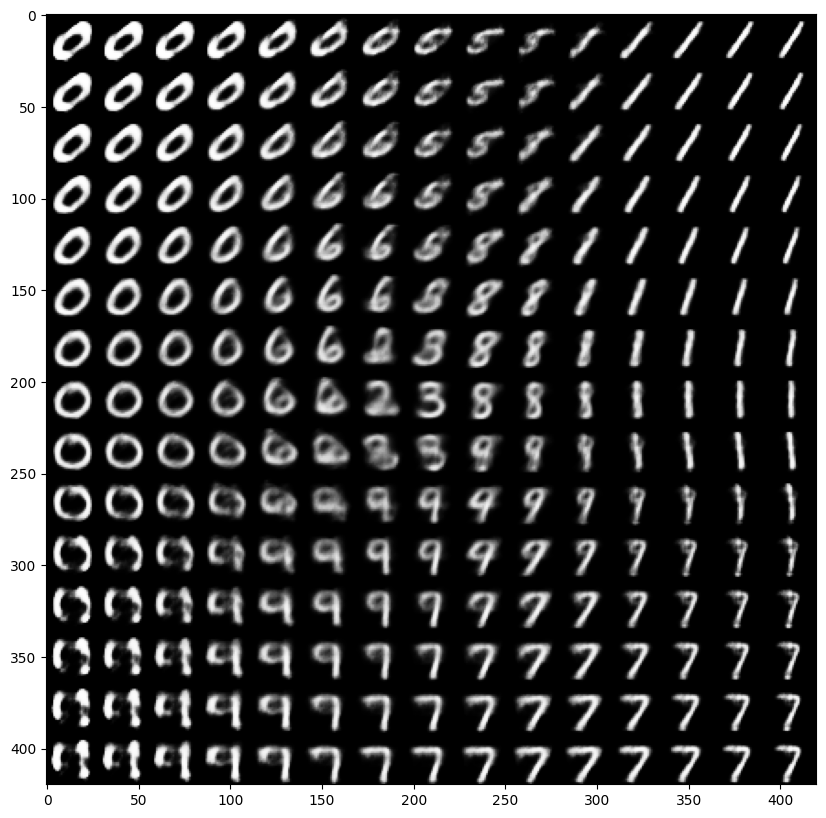

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import mean, exp, log, random_normal, square

# Load and preprocess the data
(train_images, _), (test_images, _) = mnist.load_data()
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), np.prod(train_images.shape[1:])))
test_images = test_images.reshape((len(test_images), np.prod(test_images.shape[1:])))

# Define the VAE architecture
original_dim = 784
intermediate_dim = 256
latent_dim = 2

inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)

# Latent space parameters
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = random_normal(shape=(batch, dim))
    return z_mean + exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Map sampled latent points back to reconstructed images
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# VAE model
vae = Model(inputs, x_decoded_mean)

# Loss
reconstruction_loss = binary_crossentropy(inputs, x_decoded_mean) * original_dim
kl_loss = 1 + z_log_var - square(z_mean) - exp(z_log_var)
kl_loss = -0.5 * mean(kl_loss)
vae_loss = mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

# Train the VAE
vae.fit(train_images, train_images,
        epochs=50,
        batch_size=256,
        shuffle=True,
        validation_data=(test_images, test_images))

# Visualize the results
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder_mean(decoder_h(z_sample))
        digit = tf.reshape(x_decoded[0], (digit_size, digit_size)).numpy()
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()
